In [1]:
"""
Dependencies.

- ultralytics: YOLOv8 (lightweight detection)
- opencv-python: image processing
- matplotlib: visualization
- torch: inference backend
"""

!pip install -q ultralytics opencv-python matplotlib torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.5 MB/s eta 0:00:00


In [2]:
import os

for d in ["images", "outputs"]:
    os.makedirs(d, exist_ok=True)

In [3]:
import urllib.request

image_urls = {
    "room1.jpg": "https://ultralytics.com/images/bus.jpg",
    "room2.jpg": "https://ultralytics.com/images/zidane.jpg"
}

for name, url in image_urls.items():
    urllib.request.urlretrieve(url, f"images/{name}")

In [4]:
"""
Load YOLOv8 Nano.
- Very small
- Fast on CPU
- Suitable for on-device scenarios
- Strong pretrained weights
"""

from ultralytics import YOLO

model = YOLO("yolov8n.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
"""
Run detection on a single image.
"""

import cv2

image_path = "images/room1.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = model(image_rgb)[0]


0: 640x480 4 persons, 1 bus, 366.8ms
Speed: 21.2ms preprocess, 366.8ms inference, 43.0ms postprocess per image at shape (1, 3, 640, 480)


In [6]:
"""
Extract detection results in a structured format.

Each detection includes:
- class label
- confidence
- bounding box
"""

detections = []

for box in results.boxes:
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    conf = float(box.conf[0])
    cls = int(box.cls[0])
    label = model.names[cls]

    detections.append({
        "label": label,
        "confidence": conf,
        "bbox": (x1, y1, x2, y2)
    })

detections

[{'label': 'bus',
  'confidence': 0.8677443861961365,
  'bbox': (22.424829483032227,
   228.9612274169922,
   805.1844482421875,
   750.4073486328125)},
 {'label': 'person',
  'confidence': 0.8639745712280273,
  'bbox': (48.69221878051758,
   399.3651428222656,
   243.6276092529297,
   902.8463745117188)},
 {'label': 'person',
  'confidence': 0.8326210379600525,
  'bbox': (669.6906127929688,
   378.41436767578125,
   809.8963012695312,
   869.621337890625)},
 {'label': 'person',
  'confidence': 0.8113366365432739,
  'bbox': (215.78515625,
   405.2359619140625,
   346.2652282714844,
   858.1632690429688)},
 {'label': 'person',
  'confidence': 0.334145188331604,
  'bbox': (0.0, 549.4791259765625, 61.95109558105469, 874.8444213867188)}]

In [7]:
"""
Spatial reasoning module.
- Convert bounding boxes into human-meaningful relations
- left / center / right
- near / far (approximate)

"""

def spatial_reasoning(detections, image_width):
    interpreted = []

    for det in detections:
        x1, y1, x2, y2 = det["bbox"]
        box_center = (x1 + x2) / 2
        box_width = x2 - x1

        # Horizontal position
        if box_center < image_width / 3:
            horiz = "left"
        elif box_center > 2 * image_width / 3:
            horiz = "right"
        else:
            horiz = "in front"

        # Depth proxy (very simple)
        if box_width > image_width / 3:
            depth = "near"
        else:
            depth = "far"

        interpreted.append({
            "label": det["label"],
            "position": horiz,
            "distance": depth
        })

    return interpreted

In [8]:
scene_info = spatial_reasoning(detections, image_rgb.shape[1])
scene_info

[{'label': 'bus', 'position': 'in front', 'distance': 'near'},
 {'label': 'person', 'position': 'left', 'distance': 'far'},
 {'label': 'person', 'position': 'right', 'distance': 'far'},
 {'label': 'person', 'position': 'in front', 'distance': 'far'},
 {'label': 'person', 'position': 'left', 'distance': 'far'}]

In [11]:
"""
Generate concise, useful descriptions.

Design goals:
- Short
- Actionable
- No probabilities
- No clutter
"""

def generate_description(scene_info):
    sentences = []

    for obj in scene_info:
        label = obj["label"]
        pos = obj["position"]
        dist = obj["distance"]

        sentence = f"A {label} is {dist} and {pos}."
        sentences.append(sentence)

    return " ".join(sentences)


In [12]:
description = generate_description(scene_info)
print("GUIDEDVISION OUTPUT : \n")
print(description)

GUIDEDVISION OUTPUT : 

A bus is near and in front. A person is far and left. A person is far and right. A person is far and in front. A person is far and left.


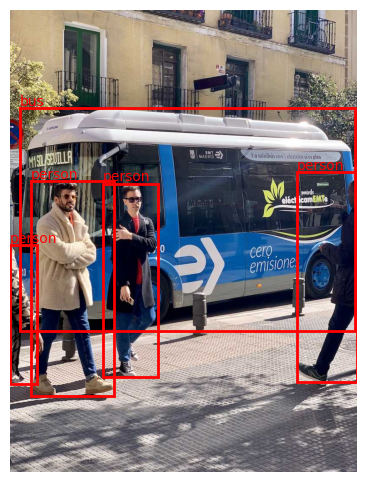

In [13]:
"""
visualization
"""

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(image_rgb)
plt.axis("off")

for det in detections:
    x1, y1, x2, y2 = det["bbox"]
    plt.gca().add_patch(
        plt.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            fill=False,
            edgecolor="red",
            linewidth=2
        )
    )
    plt.text(x1, y1 - 5, det["label"], color="red")

plt.show()

In [14]:
"""
Measure inference latency.
"""

import time

start = time.time()
_ = model(image_rgb)
latency = time.time() - start

print(f"Inference latency: {latency:.3f} seconds")


0: 640x480 4 persons, 1 bus, 193.0ms
Speed: 7.2ms preprocess, 193.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)
Inference latency: 0.209 seconds


In [15]:
"""
Importance filtering module

- Prioritize objects relevant to navigation & safety
- Reduce cognitive load for visually impaired users
"""

IMPORTANT_OBJECTS = {
    "person": 3,
    "chair": 2,
    "couch": 2,
    "bed": 2,
    "table": 2,
    "door": 3,
    "stairs": 3
}

def filter_important_objects(detections, min_conf=0.4):
    filtered = []
    for det in detections:
        label = det["label"]
        conf = det["confidence"]

        if label in IMPORTANT_OBJECTS and conf >= min_conf:
            det["importance"] = IMPORTANT_OBJECTS[label]
            filtered.append(det)

    return filtered

In [16]:
important_detections = filter_important_objects(detections)
important_detections

[{'label': 'person',
  'confidence': 0.8639745712280273,
  'bbox': (48.69221878051758,
   399.3651428222656,
   243.6276092529297,
   902.8463745117188),
  'importance': 3},
 {'label': 'person',
  'confidence': 0.8326210379600525,
  'bbox': (669.6906127929688,
   378.41436767578125,
   809.8963012695312,
   869.621337890625),
  'importance': 3},
 {'label': 'person',
  'confidence': 0.8113366365432739,
  'bbox': (215.78515625,
   405.2359619140625,
   346.2652282714844,
   858.1632690429688),
  'importance': 3}]

In [17]:
"""
Depth-aware spatial reasoning

Uses relative bounding-box area instead of raw width.
"""

def spatial_reasoning_v2(detections, image_shape):
    h, w, _ = image_shape
    image_area = h * w
    interpreted = []

    for det in detections:
        x1, y1, x2, y2 = det["bbox"]
        box_center_x = (x1 + x2) / 2
        box_area = (x2 - x1) * (y2 - y1)
        area_ratio = box_area / image_area

        # Horizontal position
        if box_center_x < w / 3:
            horiz = "to your left"
        elif box_center_x > 2 * w / 3:
            horiz = "to your right"
        else:
            horiz = "in front of you"

        # Depth estimation
        if area_ratio > 0.15:
            depth = "very close"
        elif area_ratio > 0.05:
            depth = "near"
        else:
            depth = "far"

        interpreted.append({
            "label": det["label"],
            "position": horiz,
            "distance": depth,
            "importance": det.get("importance", 1)
        })

    return interpreted

In [19]:
def description_length_score(description, max_words=20):
    words = description.split()
    return min(1.0, max_words / max(1, len(words)))

def important_object_coverage(scene_info):
    if not scene_info:
        return 0.0
    important = [o for o in scene_info if o["importance"] >= 2]
    return len(important) / len(scene_info)

def usefulness_score(description, scene_info):
    conciseness = description_length_score(description)
    coverage = important_object_coverage(scene_info)
    return 0.6 * coverage + 0.4 * conciseness

In [20]:
scene_info_v2 = spatial_reasoning_v2(important_detections, image_rgb.shape)
description = generate_description(scene_info_v2)

print(description)
print("Usefulness score:", usefulness_score(description, scene_info_v2))

A person is near and to your left. A person is near and to your right. A person is near and in front of you.
Usefulness score: 0.92


In [21]:
# Metrics

In [23]:
"""
Measure end-to-end latency:
image → detection → reasoning → description
"""

import time

def guidedvision_pipeline(image_rgb):
    results = model(image_rgb)[0]

    detections = []
    for box in results.boxes:
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        conf = float(box.conf[0])
        cls = int(box.cls[0])
        label = model.names[cls]

        detections.append({
            "label": label,
            "confidence": conf,
            "bbox": (x1, y1, x2, y2)
        })

    important = filter_important_objects(detections)
    scene_info = spatial_reasoning_v2(important, image_rgb.shape)
    description = generate_description(scene_info)

    return description, scene_info


start = time.time()
_ = guidedvision_pipeline(image_rgb)
latency = time.time() - start

print(f"End-to-end latency: {latency:.3f} seconds")


0: 640x480 4 persons, 1 bus, 151.8ms
Speed: 5.7ms preprocess, 151.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)
End-to-end latency: 0.166 seconds


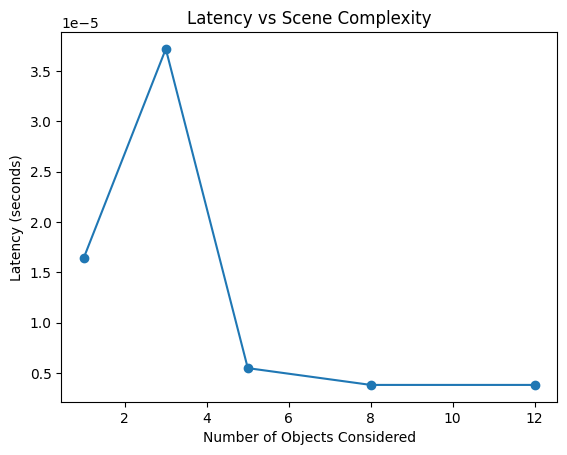

In [24]:
import matplotlib.pyplot as plt
import numpy as np

object_counts = [1, 3, 5, 8, 12]
latencies = []

for n in object_counts:
    start = time.time()
    _ = spatial_reasoning_v2(important_detections[:n], image_rgb.shape)
    latencies.append(time.time() - start)

plt.figure()
plt.plot(object_counts, latencies, marker="o")
plt.xlabel("Number of Objects Considered")
plt.ylabel("Latency (seconds)")
plt.title("Latency vs Scene Complexity")
plt.show()

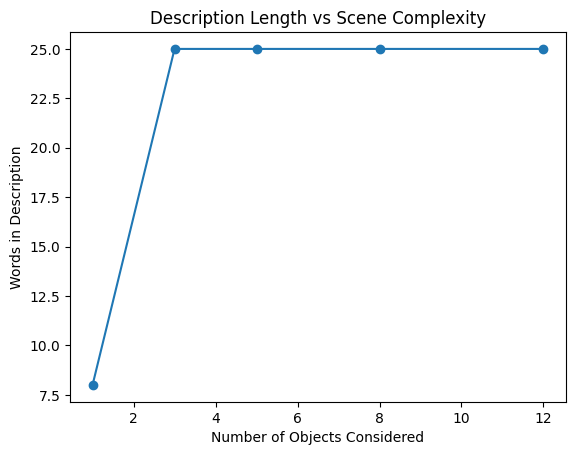

In [26]:
def description_word_count(description):
    return len(description.split())

desc_lengths = []

for n in object_counts:
    scene_info_n = spatial_reasoning_v2(
        important_detections[:n], image_rgb.shape
    )
    desc = generate_description(scene_info_n)
    desc_lengths.append(description_word_count(desc))

plt.figure()
plt.plot(object_counts, desc_lengths, marker="o")
plt.xlabel("Number of Objects Considered")
plt.ylabel("Words in Description")
plt.title("Description Length vs Scene Complexity")
plt.show()

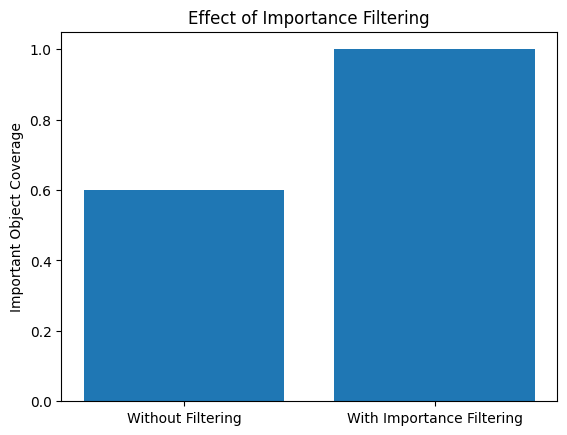

In [30]:
def important_object_coverage(scene_info):
    if not scene_info:
        return 0.0
    important = [o for o in scene_info if o["importance"] >= 2]
    return len(important) / len(scene_info)

raw_scene = spatial_reasoning_v2(detections, image_rgb.shape)
filtered_scene = spatial_reasoning_v2(important_detections, image_rgb.shape)

coverage_raw = important_object_coverage(raw_scene)
coverage_filtered = important_object_coverage(filtered_scene)

plt.figure()
plt.bar(
    ["Without Filtering", "With Importance Filtering"],
    [coverage_raw, coverage_filtered]
)
plt.ylabel("Important Object Coverage")
plt.title("Effect of Importance Filtering")
plt.show()